In [ ]:
import openmc
import numpy as np
import os
import matplotlib.pyplot as plt
#os.system('export OPENMC_CROSS_SECTIONS="/storage/work/ajg7072/NUCE_403/endf/cross_sections.xml"')
#os.environ["OPENMC_CROSS_SECTIONS"] = "/storage/work/ajg7072/NUCE_403/endf/cross_sections.xml"

## Defining materials

# This "fuel" is the classic UO2 and I added gadolinium as a burnable poison just to experiment (very sensitive to gad concentration). 
# I doubt that this is right so it will have to be revised. It should be a mix of UO2 and Gd2O3
fuel = openmc.Material(name='uo2_gad') 
fuel.add_nuclide('U235', 0.18) 
fuel.add_nuclide('U238', 0.82)
fuel.add_element('Gd', 0.00075)
fuel.add_nuclide('O16', 5) 
fuel.set_density('g/cm3', 11.5) 

cladding = openmc.Material(name='zircaloy4') 
cladding.add_element('Zr',0.98) 
cladding.add_element('Sn',0.015) 
cladding.add_element('Fe',0.002) 
cladding.add_element('Cr',0.001) 
cladding.add_element('O',0.001) 
cladding.add_element('Hf', 0.001) 
cladding.set_density('g/cm3', 6.34) 

water = openmc.Material(name='h2o') 
water.add_nuclide('H1', 2.0) 
water.add_nuclide('O16', 1.0) 
water.set_density('g/cm3', 1.0) 
water.add_s_alpha_beta('c_H_in_H2O')

ctrl_rod = openmc.Material(name='bc4')
ctrl_rod.add_nuclide('B10', 0.7)
ctrl_rod.add_nuclide('B11', 0.3)
ctrl_rod.add_nuclide('C12', 4)
ctrl_rod.set_density('g/cm3', 2.5)

rpv = openmc.Material(name='stainless_steel')   #Not really following any stablished "named" materials, just went with an approximation
rpv.add_element('Fe', 0.7)
rpv.add_element('Cr', 0.2)
rpv.add_element('Ni', 0.08)
rpv.add_element('Mn', 0.01)
rpv.add_element('C', 0.01)
rpv.set_density('g/cm3', 7.6)

mats = openmc.Materials([fuel, cladding, water, ctrl_rod, rpv]) 
mats.cross_sections = "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/cross_sections.xml"
mats.export_to_xml() 

## Defining geometry


# First defining dimensions and limiting surfaces for fuel, clad, and (when we had them) control rods
# Specify boundary conditions only to the exterior surfaces
# Changed the radius of the pellet to be more realistic (1 whole cm was a lot)

H_core = 225
R_core = 130
r_uo2=0.6
cyl_uo2 = openmc.ZCylinder(r=0.6)
cyl_clad = openmc.ZCylinder(r=0.62)
cyl_ctrl = openmc.ZCylinder(r=0.62)
cyl_no_ctrl = openmc.ZCylinder(r=0.62)
cyl_rpv_i = openmc.ZCylinder(r=R_core-10)
cyl_rpv_o = openmc.ZCylinder(r=R_core, boundary_type='vacuum')
z_max = openmc.ZPlane(z0=H_core, boundary_type='vacuum')
z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')

# regions
uo2_region = -cyl_uo2 & -z_max & +z_min
clad_region = +cyl_uo2 & -cyl_clad & -z_max & +z_min
water_region = +cyl_clad & -z_max & +z_min
ctrl_region = -cyl_ctrl & -z_max & +z_min
no_ctrl_region = -cyl_no_ctrl & -z_max & +z_min
water_ctrl_region = +cyl_ctrl & -z_max & +z_min
water_no_ctrl_region = +cyl_no_ctrl & -z_max & +z_min
rpv_region = +cyl_rpv_i & -cyl_rpv_o & -z_max & +z_min
water_rod_region = -cyl_ctrl & -z_max & +z_min

# cells
uo2_cell = openmc.Cell(name='fuel')
uo2_cell.region = uo2_region
uo2_cell.fill = fuel

clad_cell = openmc.Cell(name='cladding')
clad_cell.region = clad_region
clad_cell.fill = cladding

ctrl_cell = openmc.Cell(name='ctrl_rod')
ctrl_cell.region = ctrl_region
ctrl_cell.fill = ctrl_rod

no_ctrl_cell = openmc.Cell(name='no_ctrl_rod')
no_ctrl_cell.region = no_ctrl_region
no_ctrl_cell.fill = water

water_cell = openmc.Cell(name='water')
water_cell.region = water_region
water_cell.fill = water

water_cell_ctrl = openmc.Cell(name='water_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_ctrl.region = water_ctrl_region
water_cell_ctrl.fill = water

water_cell_no_ctrl = openmc.Cell(name='water_no_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_no_ctrl.region = water_no_ctrl_region
water_cell_no_ctrl.fill = water

rpv_cell = openmc.Cell(name='vessel')
rpv_cell.region = rpv_region
rpv_cell.fill = rpv

water_rod_cell = openmc.Cell(name='water_rod_uncontrolled')
water_rod_cell.region = water_rod_region
water_rod_cell.fill = water

# universes, the outer universe i see it as a safety net so that everything is covered

fuel_universe = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])
ctrl_rod_universe = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])
outer_universe = openmc.Universe(cells=[openmc.Cell(fill=water)])
no_ctrl_rod_universe = openmc.Universe(cells=[no_ctrl_cell, water_cell_no_ctrl])

lat = openmc.HexLattice()    # this is the lattice of the fuel pins arranged into 3 rings to form the assembly
lat.center = (0., 0.)
lat.pitch = (4.6,)           # i picked this number just to make it fit, no calculations. 
# Changing this number affects k-eff a lot. Could make it smaller and even fit one more assembly ring
lat.outer = outer_universe

outer_ring = [fuel_universe] * 12
middle_ring = [fuel_universe] * 6
inner_ring = [no_ctrl_rod_universe]         # this used to be ctrl_rod_universe, but since we need burnable poisons it needs to be uncontrolled
lat.universes = [outer_ring, middle_ring, inner_ring] # this completely defines the lattice structure


# this defines the fuel assembly cell so that it can be stacked
a = 2.75 * lat.pitch[0]  # formula
outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')
main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)

assembly_univ = openmc.Universe(cells=[main_cell]) #just "converting" the cell into a universe so that it can be merged

core_lat = openmc.HexLattice()
core_lat.center = (0.,0.)
core_lat.pitch = (np.sqrt(3)*a-0.8,)  # the sqrt3*a is the formula, then manually adjusting it so that it looks homogeneous
core_lat.outer = outer_universe # used the same outer as when defining the assemblies, it does not matter
core_lat.orientation = 'x' # these orientations are either x or y. I just change them until they agree lol

ring_1 = [assembly_univ]
ring_2 = [assembly_univ] * 6
ring_3 = [assembly_univ] * 12
ring_4 = [assembly_univ] * 18
ring_5 = [assembly_univ] * 24
ring_6 = [assembly_univ] * 30
core_lat.universes = [ring_6, ring_5, ring_4, ring_3, ring_2, ring_1]

# only the "water" of the core, no pressure vessel
whole_core_cell = openmc.Cell(fill=core_lat, region=-cyl_rpv_i & -z_max & +z_min)

geom = openmc.Geometry([whole_core_cell, rpv_cell]) #pressure vessel added here
geom.export_to_xml()

#p.to_ipython_image()
# failed trial run for tallies. We don't really need them anymore but just in case i left them here

r_grid_num = np.linspace(0,R_core,15)
z_grid_num = np.linspace(-H_core,H_core, 50)
phi_grid_num = np.array([0, 2*np.pi])

mesh = openmc.CylindricalMesh(
    r_grid = r_grid_num,
    z_grid = z_grid_num,
    phi_grid = phi_grid_num,
    origin = (0.0,0.0,0.0)
)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name='raw_flux')
flux_tally.filter = [mesh_filter]
flux_tally.scores = ['flux']

tallies = openmc.Tallies([flux_tally])
#tallies.export_to_xml()


###############################################################################
#                     Set volumes of depletable materials
###############################################################################

# Set material volume for depletion. For 2D simulations, this should be an area.
#uo2.volume = pi * cyl_uo2.r**2 *H_core*2286   #whole core, with 2286 pins

###############################################################################
#                     Transport calculation settings
###############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 500
settings.inactive = 10
settings.particles = 200000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -1, 0.62992, 0.62992, 1]   #Marked for further discu.
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:])
settings.source = openmc.IndependentSource(
    space=uniform_dist, constraints={'fissionable': True})

###############################################################################
#                   Initialize and run depletion calculation
############################################################################
 # Depletion Cell
import openmc.deplete
fuel.volume = np.pi * cyl_uo2.r**2 *H_core*2286   #2286 pins
chain = openmc.deplete.Chain.from_xml("/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/chain_simple.xml")
model = openmc.Model(geometry=geom, materials=mats, settings=settings)
operator = openmc.deplete.CoupledOperator(
    model,
    "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/chain_simple.xml",
)

power = 20e6 #W
time_steps = [0.1, 0.2, 0.4, 0.8,1.6,2.5,5,
             10,20,40,80,160,320,640,1280,2560,5120]  # test only
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d') # also better options available
integrator.integrate()


openmc.run(threads=4) #aiden's contribution

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "
[DjamondsLaptop:81769] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/4002676736/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:81769] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading H1 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/H1.h5
 Reading B10 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/B10.h5
 Reading B11 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/B11.h5
 Reading C12 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/C12.h5
 Reading C13 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/C13.h5
 Reading Mn55 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Mn55.h5
 Reading Ni58 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni58.h5
 Reading Ni60 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni60.h5
 Reading Ni61 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni61.h5
 Reading Ni62 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni62.h5
 Reading Ni64 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni64.h5
 Reading c_

 Reading Xe135 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Xe135.h5
 Reading Xe136 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Xe136.h5
 Reading Cs135 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Cs135.h5
 Reading U234 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/U234.h5


In [ ]:

import numpy as np 

import os 

import math 

#os.environ["PATH"] = "/storage/work/ugh5000/.conda/envs/openmc/bin:" + os.environ["PATH"] 

import openmc 

#os.environ["OPENMC_CROSS_SECTIONS"] = "/storage/work/ugh5000/openmc_xs/endfb-viii.0-hdf5/cross_sections.xml"

#os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"



## Defining materials



# This "fuel" is the classic UO2 and I added gadolinium as a burnable poison just to experiment (very sensitive to gad concentration). 

# I doubt that this is right so it will have to be revised. It should be a mix of UO2 and Gd2O3

fuel = openmc.Material(name='uo2_gad') 

fuel.add_nuclide('U235', 0.18) 

fuel.add_nuclide('U238', 0.82)

fuel.add_element('Gd', 0.00075)

fuel.add_nuclide('O16', 5) 

fuel.set_density('g/cm3', 11.5) 



cladding = openmc.Material(name='zircaloy4') 

cladding.add_element('Zr',0.98) 

cladding.add_element('Sn',0.015) 

cladding.add_element('Fe',0.002) 

cladding.add_element('Cr',0.001) 

cladding.add_element('O',0.001) 

cladding.add_element('Hf', 0.001) 

cladding.set_density('g/cm3', 6.34) 



water = openmc.Material(name='h2o') 

water.add_nuclide('H1', 2.0) 

water.add_nuclide('O16', 1.0) 

water.set_density('g/cm3', 1.0) 

water.add_s_alpha_beta('c_H_in_H2O')



ctrl_rod = openmc.Material(name='bc4')

ctrl_rod.add_nuclide('B10', 0.7)

ctrl_rod.add_nuclide('B11', 0.3)

ctrl_rod.add_nuclide('C12', 4)

ctrl_rod.set_density('g/cm3', 2.5)



rpv = openmc.Material(name='stainless_steel')   #Not really following any stablished "named" materials, just went with an approximation

rpv.add_element('Fe', 0.7)

rpv.add_element('Cr', 0.2)

rpv.add_element('Ni', 0.08)

rpv.add_element('Mn', 0.01)

rpv.add_element('C', 0.01)

rpv.set_density('g/cm3', 7.6)



mats = openmc.Materials([fuel, cladding, water, ctrl_rod, rpv]) 

mats.cross_sections = "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/chain_simple.xml"

mats.export_to_xml() 







## Defining geometry





# First defining dimensions and limiting surfaces for fuel, clad, and (when we had them) control rods

# Specify boundary conditions only to the exterior surfaces

# Changed the radius of the pellet to be more realistic (1 whole cm was a lot)



H_core = 225

R_core = 150

cyl_uo2 = openmc.ZCylinder(r=0.6)

cyl_clad = openmc.ZCylinder(r=0.62)

cyl_ctrl = openmc.ZCylinder(r=0.62)

cyl_no_ctrl = openmc.ZCylinder(r=0.62)

cyl_rpv_i = openmc.ZCylinder(r=R_core-10)

cyl_rpv_o = openmc.ZCylinder(r=R_core, boundary_type='vacuum')

z_max = openmc.ZPlane(z0=H_core, boundary_type='vacuum')

z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')



# regions

uo2_region = -cyl_uo2 & -z_max & +z_min

clad_region = +cyl_uo2 & -cyl_clad & -z_max & +z_min

water_region = +cyl_clad & -z_max & +z_min

ctrl_region = -cyl_ctrl & -z_max & +z_min

no_ctrl_region = -cyl_no_ctrl & -z_max & +z_min

water_ctrl_region = +cyl_ctrl & -z_max & +z_min

water_no_ctrl_region = +cyl_no_ctrl & -z_max & +z_min

rpv_region = +cyl_rpv_i & -cyl_rpv_o & -z_max & +z_min

water_rod_region = -cyl_ctrl & -z_max & +z_min



# cells

uo2_cell = openmc.Cell(name='fuel')

uo2_cell.region = uo2_region

uo2_cell.fill = fuel



clad_cell = openmc.Cell(name='cladding')

clad_cell.region = clad_region

clad_cell.fill = cladding



ctrl_cell = openmc.Cell(name='ctrl_rod')

ctrl_cell.region = ctrl_region

ctrl_cell.fill = ctrl_rod



no_ctrl_cell = openmc.Cell(name='no_ctrl_rod')

no_ctrl_cell.region = no_ctrl_region

no_ctrl_cell.fill = water



water_cell = openmc.Cell(name='water')

water_cell.region = water_region

water_cell.fill = water



water_cell_ctrl = openmc.Cell(name='water_ctrl')        # This might be unnecessary, essentially the same as the water cell

water_cell_ctrl.region = water_ctrl_region

water_cell_ctrl.fill = water



water_cell_no_ctrl = openmc.Cell(name='water_no_ctrl')        # This might be unnecessary, essentially the same as the water cell

water_cell_no_ctrl.region = water_no_ctrl_region

water_cell_no_ctrl.fill = water



rpv_cell = openmc.Cell(name='vessel')

rpv_cell.region = rpv_region

rpv_cell.fill = rpv



water_rod_cell = openmc.Cell(name='water_rod_uncontrolled')

water_rod_cell.region = water_rod_region

water_rod_cell.fill = water



# universes, the outer universe i see it as a safety net so that everything is covered



fuel_universe = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])

ctrl_rod_universe = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])

outer_universe = openmc.Universe(cells=[openmc.Cell(fill=water)])

no_ctrl_rod_universe = openmc.Universe(cells=[no_ctrl_cell, water_cell_no_ctrl])



lat = openmc.HexLattice()    # this is the lattice of the fuel pins arranged into 3 rings to form the assembly

lat.center = (0., 0.)

lat.pitch = (4.6,)           # i picked this number just to make it fit, no calculations. 

# Changing this number affects k-eff a lot. Could make it smaller and even fit one more assembly ring

lat.outer = outer_universe



outer_ring = [fuel_universe] * 12

middle_ring = [fuel_universe] * 6

inner_ring = [no_ctrl_rod_universe]         # this used to be ctrl_rod_universe, but since we need burnable poisons it needs to be uncontrolled

lat.universes = [outer_ring, middle_ring, inner_ring] # this completely defines the lattice structure





# this defines the fuel assembly cell so that it can be stacked

a = 2.75 * lat.pitch[0]  # formula

outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')

main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)



assembly_univ = openmc.Universe(cells=[main_cell]) #just "converting" the cell into a universe so that it can be merged



core_lat = openmc.HexLattice()

core_lat.center = (0.,0.)

core_lat.pitch = (np.sqrt(3)*a-0.8,)  # the sqrt3*a is the formula, then manually adjusting it so that it looks homogeneous

core_lat.outer = outer_universe # used the same outer as when defining the assemblies, it does not matter

core_lat.orientation = 'x' # these orientations are either x or y. I just change them until they agree lol



ring_1 = [assembly_univ]

ring_2 = [assembly_univ] * 6

ring_3 = [assembly_univ] * 12

ring_4 = [assembly_univ] * 18

ring_5 = [assembly_univ] * 24

ring_6 = [assembly_univ] * 30

ring_7 = [assembly_univ] * 36

core_lat.universes = [ring_7, ring_6, ring_5, ring_4, ring_3, ring_2, ring_1]



# only the "water" of the core, no pressure vessel

whole_core_cell = openmc.Cell(fill=core_lat, region=-cyl_rpv_i & -z_max & +z_min)



geom = openmc.Geometry([whole_core_cell, rpv_cell]) #pressure vessel added here

geom.export_to_xml()

settings = openmc.Settings()

settings.batches = 500

settings.inactive = 10

settings.particles = 200000

settings.run_mode = 'eigenvalue'

settings.temperature = {'method': 'interpolation', 'tolerance' : 200,'range' : [1,1400]}

settings.export_to_xml()

for temp in np.linspace(373,973,11):

    for tempmod in np.linspace(373,973,11):

        fuel.temperature=temp

        cladding.temperature=temp

        water.temperature=tempmod


        mats.export_to_xml()

        openmc.run(threads=4)

        os.rename('statepoint.100.h5',f'{temp}_{tempmod}.h5')

        

Moderator temperatures found in files (K):
[373.0, 433.0, 493.0, 553.0, 613.0, 673.0, 733.0, 793.0, 853.0, 913.0, 973.0]

Requested T_mod ≈ 600.0 K; using closest available: 613.0 K

Data points used (T_fuel [K], ρ [pcm]):
     373.0   15099.122
     433.0   15187.940
     493.0   15206.975
     553.0   15332.752


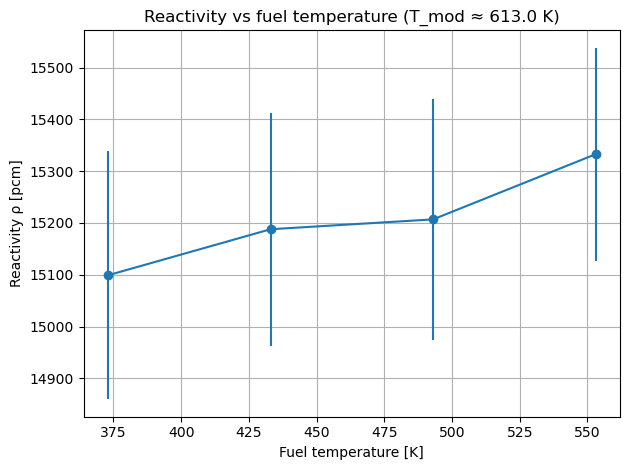


Fuel temperature coefficient at T_mod ≈ 613.0 K:
  alpha_F ≈ 1.200 pcm/K


In [8]:
import os
import glob
import numpy as np
import openmc
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0) Directory with statepoint .h5 files
# ---------------------------------------------------------
STATEPOINT_DIR = "/mnt/c/Users/djamo/Downloads/tempdistri"

# If you want a specific moderator temperature, put it here.
# The script will pick the closest available value in the files.
DESIRED_T_MOD = 600  # K (approximate value; script snaps to nearest)

# ---------------------------------------------------------
# 1) Discover available (T_fuel, T_mod) pairs from filenames
# ---------------------------------------------------------
pattern = os.path.join(STATEPOINT_DIR, "*.h5")
statepoint_files = glob.glob(pattern)

if len(statepoint_files) == 0:
    raise RuntimeError(f"No .h5 files found in {STATEPOINT_DIR}")

pairs = set()
for fname in statepoint_files:
    base = os.path.splitext(os.path.basename(fname))[0]  # e.g. "373.0_573.0"
    try:
        T_fuel, T_mod = map(float, base.split("_"))
        pairs.add((T_fuel, T_mod))
    except ValueError:
        # Skip files whose names don't match "fuel_mod.h5" pattern
        continue

if len(pairs) == 0:
    raise RuntimeError("No valid 'Tfuel_Tmod.h5' filenames found in directory.")

all_Tmod = sorted({T_mod for (_, T_mod) in pairs})

print("Moderator temperatures found in files (K):")
print(all_Tmod)

# Choose moderator temperature closest to DESIRED_T_MOD
actual_T_mod = min(all_Tmod, key=lambda t: abs(t - DESIRED_T_MOD))
print(f"\nRequested T_mod ≈ {DESIRED_T_MOD:.1f} K; using closest available: {actual_T_mod:.1f} K\n")

# ---------------------------------------------------------
# 2) Collect ρ(T_fuel) data for this moderator temperature
# ---------------------------------------------------------
fuel_temps = []
rho_pcm = []
rho_pcm_err = []

for fname in statepoint_files:
    base = os.path.splitext(os.path.basename(fname))[0]
    try:
        T_fuel, T_mod = map(float, base.split("_"))
    except ValueError:
        continue

    # Select only points with this moderator temperature
    if abs(T_mod - actual_T_mod) > 1e-6:
        continue

    sp = openmc.StatePoint(fname)

    # Handle both newer and older OpenMC APIs
    try:
        # Newer: sp.keff is an uncertainties.UFloat
        keff_var = sp.keff
        keff_mean = keff_var.nominal_value
        keff_std = keff_var.std_dev
    except AttributeError:
        # Older: sp.k_combined is [mean, std]
        keff_mean, keff_std = sp.k_combined

    # Reactivity and uncertainty
    rho = (keff_mean - 1.0) / keff_mean          # dimensionless
    rho_err = keff_std / (keff_mean**2)          # dρ/dk = 1/k^2

    fuel_temps.append(T_fuel)
    rho_pcm.append(rho * 1.0e5)                  # pcm
    rho_pcm_err.append(rho_err * 1.0e5)          # pcm

fuel_temps = np.array(fuel_temps)
rho_pcm = np.array(rho_pcm)
rho_pcm_err = np.array(rho_pcm_err)

if fuel_temps.size == 0:
    raise RuntimeError(
        f"No data points found for moderator temperature {actual_T_mod:.1f} K."
        " Check that filenames are 'Tfuel_Tmod.h5' and that the directory is correct."
    )

# Sort by fuel temperature for a clean plot / fit
idx = np.argsort(fuel_temps)
fuel_temps = fuel_temps[idx]
rho_pcm = rho_pcm[idx]
rho_pcm_err = rho_pcm_err[idx]

print("Data points used (T_fuel [K], ρ [pcm]):")
for T_f, r in zip(fuel_temps, rho_pcm):
    print(f"  {T_f:8.1f}  {r: .3f}")

# ---------------------------------------------------------
# 3) Plot reactivity vs fuel temperature
# ---------------------------------------------------------
plt.errorbar(fuel_temps, rho_pcm, yerr=rho_pcm_err, fmt="o-")
plt.xlabel("Fuel temperature [K]")
plt.ylabel("Reactivity ρ [pcm]")
plt.title(f"Reactivity vs fuel temperature (T_mod ≈ {actual_T_mod:.1f} K)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4) Linear fit to get temperature coefficient
# ---------------------------------------------------------
if fuel_temps.size < 2:
    raise RuntimeError("Need at least two temperatures to fit a slope.")

coeffs = np.polyfit(fuel_temps, rho_pcm, 1)  # ρ = a*T + b
alpha_F = coeffs[0]                          # pcm/K

print(f"\nFuel temperature coefficient at T_mod ≈ {actual_T_mod:.1f} K:")
print(f"  alpha_F ≈ {alpha_F:.3f} pcm/K")


Isothermal data points (T [K], ρ [pcm]):
     373.0   5987.218
     433.0   8636.194
     493.0   11298.391
     553.0   12972.948


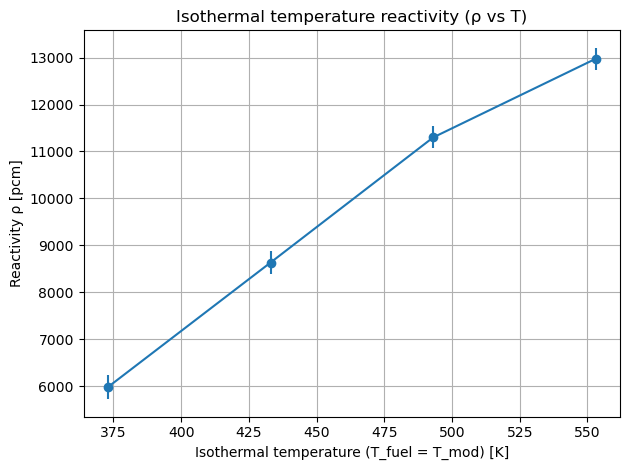


Isothermal temperature reactivity coefficient (T_fuel = T_mod):
  alpha_T ≈ 39.366 pcm/K


In [9]:
import os
import glob
import numpy as np
import openmc
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0) Directory with statepoint .h5 files
# ---------------------------------------------------------
STATEPOINT_DIR = "/mnt/c/Users/djamo/Downloads/tempdistri"

# Tolerance to regard T_fuel and T_mod as "equal"
DIAGONAL_TOL = 1e-6  # K

# ---------------------------------------------------------
# 1) Collect isothermal points: T_fuel ≈ T_mod
# ---------------------------------------------------------
pattern = os.path.join(STATEPOINT_DIR, "*.h5")
statepoint_files = glob.glob(pattern)

if len(statepoint_files) == 0:
    raise RuntimeError(f"No .h5 files found in {STATEPOINT_DIR}")

iso_temps = []
rho_pcm = []
rho_pcm_err = []

for fname in statepoint_files:
    base = os.path.splitext(os.path.basename(fname))[0]  # e.g. "373.0_373.0"
    try:
        T_fuel, T_mod = map(float, base.split("_"))
    except ValueError:
        # Skip any file that doesn't match "Tfuel_Tmod.h5"
        continue

    # Keep only points where fuel and moderator temperatures are equal
    if abs(T_fuel - T_mod) > DIAGONAL_TOL:
        continue

    # Common temperature for this isothermal point
    T_iso = T_fuel  # == T_mod within tolerance

    # Open the statepoint and get k_eff
    sp = openmc.StatePoint(fname)

    # Handle both newer and older OpenMC APIs
    try:
        # Newer: sp.keff is an uncertainties.UFloat
        keff_var = sp.keff
        keff_mean = keff_var.nominal_value
        keff_std = keff_var.std_dev
    except AttributeError:
        # Older: sp.k_combined is [mean, std]
        keff_mean, keff_std = sp.k_combined

    # Reactivity and its uncertainty
    # ρ = (k - 1)/k; dρ/dk = 1/k^2
    rho = (keff_mean - 1.0) / keff_mean         # dimensionless
    rho_err = keff_std / (keff_mean**2)         # dimensionless

    iso_temps.append(T_iso)
    rho_pcm.append(rho * 1.0e5)                 # pcm
    rho_pcm_err.append(rho_err * 1.0e5)         # pcm

iso_temps = np.array(iso_temps)
rho_pcm = np.array(rho_pcm)
rho_pcm_err = np.array(rho_pcm_err)

if iso_temps.size == 0:
    raise RuntimeError(
        "No isothermal points found (T_fuel ≈ T_mod). "
        "Check that filenames are 'Tfuel_Tmod.h5' and that some runs used "
        "the same fuel and moderator temperatures."
    )

# Sort by temperature for cleaner plots and fits
idx = np.argsort(iso_temps)
iso_temps = iso_temps[idx]
rho_pcm = rho_pcm[idx]
rho_pcm_err = rho_pcm_err[idx]

print("Isothermal data points (T [K], ρ [pcm]):")
for T, r in zip(iso_temps, rho_pcm):
    print(f"  {T:8.1f}  {r: .3f}")

# ---------------------------------------------------------
# 2) Plot reactivity vs isothermal temperature
# ---------------------------------------------------------
plt.errorbar(iso_temps, rho_pcm, yerr=rho_pcm_err, fmt="o-")
plt.xlabel("Isothermal temperature (T_fuel = T_mod) [K]")
plt.ylabel("Reactivity ρ [pcm]")
plt.title("Isothermal temperature reactivity (ρ vs T)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 3) Linear fit to get isothermal temperature coefficient
# ---------------------------------------------------------
if iso_temps.size < 2:
    raise RuntimeError("Need at least two temperatures to fit a slope.")

coeffs = np.polyfit(iso_temps, rho_pcm, 1)  # ρ = a*T + b
alpha_iso = coeffs[0]                        # pcm/K

print("\nIsothermal temperature reactivity coefficient (T_fuel = T_mod):")
print(f"  alpha_T ≈ {alpha_iso:.3f} pcm/K")


/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:74938] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/427622400/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:74938] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%

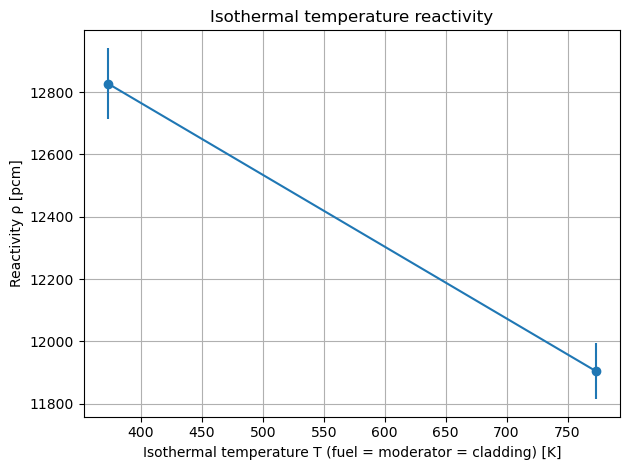

Isothermal temperature reactivity coefficient:
  alpha_T ≈ -2.306 pcm/K


In [28]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import numpy as np
import matplotlib.pyplot as plt
import openmc

# ----------------------------------------------------------------------
# Cross section library
# ----------------------------------------------------------------------
XS_PATH = "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/cross_sections.xml"
openmc.config['cross_sections'] = XS_PATH

# ----------------------------------------------------------------------
# Helper functions: temperature-dependent densities
# ----------------------------------------------------------------------

# Try to use IAPWS-97 for water at 15 MPa; fallback to simple approximation
try:
    from iapws import IAPWS97
    HAVE_IAPWS = True
except ImportError:
    HAVE_IAPWS = False

def water_density_15MPa_g_cm3(T_K: float) -> float:
    """
    Liquid water density [g/cm^3] at 15 MPa as a function of temperature [K].
    Uses IAPWS-97 if available; otherwise uses a simple linear fit between 300–350°C.
    """
    if HAVE_IAPWS:
        w = IAPWS97(P=15.0, T=T_K)      # P in MPa, T in K
        return w.rho / 1000.0           # kg/m^3 -> g/cm^3
    else:
        # Approximate near 15 MPa:
        # ~0.72 g/cm3 at 300°C (573 K); ~0.65 g/cm3 at 350°C (623 K)
        T1, rho1 = 573.15, 0.72
        T2, rho2 = 623.15, 0.65
        if T_K <= T1:
            return rho1
        elif T_K >= T2:
            return rho2
        else:
            return rho1 + (rho2 - rho1) * (T_K - T1) / (T2 - T1)

def fuel_density_g_cm3(T_K: float,
                       T_ref: float = 600.0,
                       rho_ref: float = 11.5) -> float:
    """
    Simple fuel volumetric thermal expansion model for UO2(+Gd):
    rho(T) = rho_ref / (1 + alpha_vol * (T - T_ref)).
    """
    alpha_lin = 1.0e-5           # ~1e-5 1/K linear coefficient
    alpha_vol = 3.0 * alpha_lin  # volumetric
    return rho_ref / (1.0 + alpha_vol * (T_K - T_ref))

# ----------------------------------------------------------------------
# Reference temperature for initial material definition
# ----------------------------------------------------------------------
T_ref = 600.0  # K

# ----------------------------------------------------------------------
# Materials
# ----------------------------------------------------------------------
fuel = openmc.Material(name='uo2_gad')
fuel.add_nuclide('U235', 0.02)
fuel.add_nuclide('U238', 0.98)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', fuel_density_g_cm3(T_ref))
fuel.temperature = T_ref

cladding = openmc.Material(name='zircaloy4')
cladding.add_element('Zr', 0.98)
cladding.add_element('Sn', 0.015)
cladding.add_element('Fe', 0.002)
cladding.add_element('Cr', 0.001)
cladding.add_element('O', 0.001)
cladding.add_element('Hf', 0.001)
cladding.set_density('g/cm3', 6.34)
cladding.temperature = T_ref

water = openmc.Material(name='h2o')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', water_density_15MPa_g_cm3(T_ref))
water.add_s_alpha_beta('c_H_in_H2O')
water.temperature = T_ref

boron_ppm_const = 1000
water_material = openmc.model.borated_water(
    boron_ppm = boron_ppm_const, 
    temperature = T_ref, 
    pressure = 15
)

ctrl_rod = openmc.Material(name='bc4')
ctrl_rod.add_nuclide('B10', 0.7)
ctrl_rod.add_nuclide('B11', 0.3)
ctrl_rod.add_nuclide('C12', 4.0)
ctrl_rod.set_density('g/cm3', 2.5)
ctrl_rod.temperature = T_ref

rpv = openmc.Material(name='stainless_steel')
rpv.add_element('Fe', 0.7)
rpv.add_element('Cr', 0.2)
rpv.add_element('Ni', 0.08)
rpv.add_element('Mn', 0.01)
rpv.add_element('C', 0.01)
rpv.set_density('g/cm3', 7.6)
rpv.temperature = T_ref

mats = openmc.Materials([fuel, cladding, water, ctrl_rod, rpv])
mats.cross_sections = XS_PATH

# ----------------------------------------------------------------------
# Geometry
# ----------------------------------------------------------------------
H_core = 225.0
R_core = 70

cyl_uo2   = openmc.ZCylinder(r=0.6)
cyl_clad  = openmc.ZCylinder(r=0.62)
cyl_ctrl  = openmc.ZCylinder(r=0.62)
cyl_no_ctrl = openmc.ZCylinder(r=0.62)
cyl_rpv_i = openmc.ZCylinder(r=R_core - 10.0)
cyl_rpv_o = openmc.ZCylinder(r=R_core, boundary_type='vacuum')
z_max = openmc.ZPlane(z0=H_core,  boundary_type='vacuum')
z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')

uo2_region           = -cyl_uo2     & -z_max & +z_min
clad_region          = +cyl_uo2     & -cyl_clad & -z_max & +z_min
water_region         = +cyl_clad    & -z_max & +z_min
ctrl_region          = -cyl_ctrl    & -z_max & +z_min
no_ctrl_region       = -cyl_no_ctrl & -z_max & +z_min
water_ctrl_region    = +cyl_ctrl    & -z_max & +z_min
water_no_ctrl_region = +cyl_no_ctrl & -z_max & +z_min
rpv_region           = +cyl_rpv_i   & -cyl_rpv_o & -z_max & +z_min
water_rod_region     = -cyl_ctrl    & -z_max & +z_min

uo2_cell          = openmc.Cell(name='fuel',      region=uo2_region,      fill=fuel)
clad_cell         = openmc.Cell(name='cladding',  region=clad_region,     fill=cladding)
ctrl_cell         = openmc.Cell(name='ctrl_rod',  region=ctrl_region,     fill=ctrl_rod)
no_ctrl_cell      = openmc.Cell(name='no_ctrl_rod', region=no_ctrl_region, fill=water)
water_cell        = openmc.Cell(name='water',     region=water_region,    fill=water)
water_cell_ctrl   = openmc.Cell(name='water_ctrl',
                                region=water_ctrl_region, fill=water)
water_cell_no_ctrl = openmc.Cell(name='water_no_ctrl',
                                 region=water_no_ctrl_region, fill=water)
rpv_cell          = openmc.Cell(name='vessel',    region=rpv_region,      fill=rpv)
water_rod_cell    = openmc.Cell(name='water_rod_uncontrolled',
                                region=water_rod_region, fill=water)

fuel_universe         = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])
ctrl_rod_universe     = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])
outer_universe        = openmc.Universe(cells=[openmc.Cell(fill=water)])
no_ctrl_rod_universe  = openmc.Universe(cells=[no_ctrl_cell, water_cell_no_ctrl])

lat = openmc.HexLattice()
lat.center = (0.0, 0.0)
lat.pitch  = (2.5,)
lat.outer  = outer_universe

outer_ring  = [fuel_universe] * 12
middle_ring = [fuel_universe] * 6
inner_ring  = [ctrl_rod_universe]
lat.universes = [outer_ring, middle_ring, inner_ring]

a = 2.75 * lat.pitch[0]
outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')
main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)
assembly_univ = openmc.Universe(cells=[main_cell])

core_lat = openmc.HexLattice()
core_lat.center = (0.0, 0.0)
core_lat.pitch  = (np.sqrt(3.0) * a,)
core_lat.outer  = outer_universe
core_lat.orientation = 'x'

ring_1 = [assembly_univ]
ring_2 = [assembly_univ] * 6
ring_3 = [assembly_univ] * 12
ring_4 = [assembly_univ] * 18
ring_5 = [assembly_univ] * 24
core_lat.universes = [ring_5, ring_4, ring_3, ring_2, ring_1]

whole_core_cell = openmc.Cell(fill=core_lat,
                              region=-cyl_rpv_i & -z_max & +z_min)
geom = openmc.Geometry([whole_core_cell, rpv_cell])

# ----------------------------------------------------------------------
# Settings (no bad external source constraint)
# ----------------------------------------------------------------------
settings = openmc.Settings()
settings.batches   = 100
settings.inactive  = 50
settings.particles = 10_000
settings.run_mode  = 'eigenvalue'

settings.temperature = {
    'method': 'interpolation',
    'default': T_ref,
    'range': (300.0, 1500.0)
}

# Use geometry bounding box and restrict to fissionable regions
# ----------------------------------------------------------------------
# Source distribution: box matching the core region (no fissionable filter)
# ----------------------------------------------------------------------
core_radius = R_core - 10.0      # same as inner vessel radius (cyl_rpv_i)
lower_left  = (-core_radius, -core_radius, -H_core)
upper_right = ( core_radius,  core_radius,  H_core)

source_space = openmc.stats.Box(lower_left, upper_right)  # no only_fissionable
settings.source = openmc.IndependentSource(space=source_space)

# ----------------------------------------------------------------------
# Model
# ----------------------------------------------------------------------
model = openmc.Model(geometry=geom, materials=mats, settings=settings)

# ----------------------------------------------------------------------
# Isothermal temperature sweep: T_fuel = T_mod = T_clad
# ----------------------------------------------------------------------
temps = np.linspace(373, 773, 2)  # K (example: 300–400°C)

keff_means = []
keff_stds  = []
rho_pcm    = []
rho_pcm_err = []

for T in temps:
    # Set material temperatures
    fuel.temperature     = T
    cladding.temperature = T
    water.temperature    = T
    ctrl_rod.temperature = T
    rpv.temperature      = T

    # Update densities with temperature
    fuel.set_density('g/cm3', fuel_density_g_cm3(T))
    water.set_density('g/cm3', water_density_15MPa_g_cm3(T))

    # Update default temperature for interpolation
    settings.temperature['default'] = T

    # Run OpenMC and read keff
    sp_filename = model.run()
    sp = openmc.StatePoint(sp_filename, autolink=False)

    try:
        k_var = sp.keff        # newer API: uncertainties.UFloat
        k_mean = k_var.nominal_value
        k_std  = k_var.std_dev
    except AttributeError:
        k_mean, k_std = sp.k_combined  # older API

    keff_means.append(k_mean)
    keff_stds.append(k_std)

    # Reactivity ρ = (k - 1)/k ; dρ/dk = 1/k^2
    rho = (k_mean - 1.0) / k_mean
    rho_err = k_std / (k_mean ** 2)

    rho_pcm.append(rho * 1.0e5)
    rho_pcm_err.append(rho_err * 1.0e5)

temps       = np.array(temps)
keff_means  = np.array(keff_means)
keff_stds   = np.array(keff_stds)
rho_pcm     = np.array(rho_pcm)
rho_pcm_err = np.array(rho_pcm_err)

# ----------------------------------------------------------------------
# Plot reactivity vs isothermal temperature
# ----------------------------------------------------------------------
plt.errorbar(temps, rho_pcm, yerr=rho_pcm_err, fmt="o-")
plt.xlabel("Isothermal temperature T (fuel = moderator = cladding) [K]")
plt.ylabel("Reactivity ρ [pcm]")
plt.title("Isothermal temperature reactivity")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Fit isothermal temperature coefficient
# ----------------------------------------------------------------------
if temps.size >= 2:
    coeffs = np.polyfit(temps, rho_pcm, 1)  # ρ = a T + b
    alpha_T = coeffs[0]                     # pcm/K
    print("Isothermal temperature reactivity coefficient:")
    print(f"  alpha_T ≈ {alpha_T:.3f} pcm/K")
else:
    print("Not enough temperature points to fit a coefficient.")



=== Running pitch = 2.200 cm ===


/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:62033] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/2301886464/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:62033] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:62334] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/2109145088/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:62334] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:62619] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/1447428096/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:62619] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:62912] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/1226047488/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:62912] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:63198] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/2865233920/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:63198] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:63501] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/1037238272/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:63501] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:63797] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/2082013184/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:63797] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


[DjamondsLaptop:64084] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/2440101888/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:64084] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%

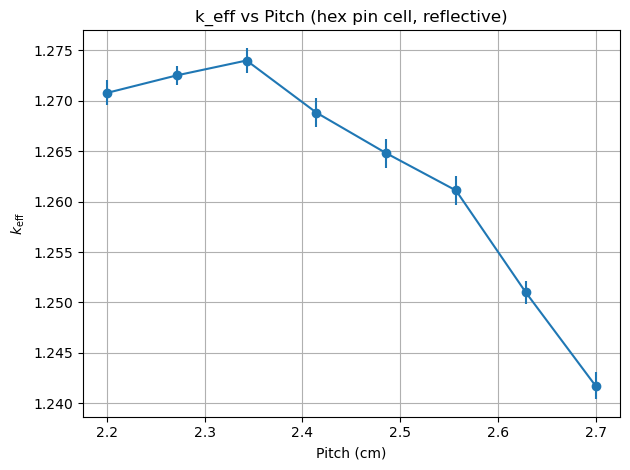

In [19]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import numpy as np
import matplotlib.pyplot as plt
import openmc

# ----------------------------------------------------------------------
# Cross-section library
# ----------------------------------------------------------------------
XS_PATH = "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/cross_sections.xml"
openmc.config['cross_sections'] = XS_PATH

# ----------------------------------------------------------------------
# Global parameters (units: cm, K)
# ----------------------------------------------------------------------
R_FUEL = 0.60     # fuel radius (cm)
R_CLAD = 0.62     # cladding outer radius (cm)
H      = 100.0    # axial height of model domain (cm), reflective
T_REF  = 600.0    # temperature (K) for all materials

# ----------------------------------------------------------------------
# Materials
# ----------------------------------------------------------------------
def make_materials():
    fuel = openmc.Material(name='uo2')
    fuel.add_nuclide('U235', 0.02)
    fuel.add_nuclide('U238', 0.98)
    fuel.add_nuclide('O16', 5.0)
    fuel.set_density('g/cm3', 11.5)   # example UO2 density
    fuel.temperature = T_REF

    cladding = openmc.Material(name='zircaloy4')
    cladding.add_element('Zr', 0.98)
    cladding.add_element('Sn', 0.015)
    cladding.add_element('Fe', 0.002)
    cladding.add_element('Cr', 0.002)
    cladding.add_element('O', 0.001)
    cladding.set_density('g/cm3', 6.55)
    cladding.temperature = T_REF

    water = openmc.Material(name='h2o')
    water.add_nuclide('H1', 2.0)
    water.add_nuclide('O16', 1.0)
    water.set_density('g/cm3', 0.70)  # ~PWR hot density (approx)
    water.add_s_alpha_beta('c_H_in_H2O')
    water.temperature = T_REF

    boron_ppm_const = 2000
    water_material = openmc.model.borated_water(
        boron_ppm = boron_ppm_const, 
        temperature = T_REF, 
        pressure = 15
    )

    mats = openmc.Materials([fuel, cladding, water])
    mats.cross_sections = XS_PATH
    return mats, fuel, cladding, water

# ----------------------------------------------------------------------
# Fuel-to-moderator ratio for a hex cell (2D)
# ----------------------------------------------------------------------
def fuel_to_moderator_ratio(pitch_cm: float) -> float:
    """
    Fuel-to-moderator volume ratio for a single hex cell with face-to-face
    pitch 'pitch_cm':

      A_hex  = (sqrt(3)/2) * pitch^2
      A_fuel = π R_FUEL^2
      A_clad = π (R_CLAD^2 - R_FUEL^2)
      A_mod  = A_hex - A_fuel - A_clad

      V_fuel / V_mod = A_fuel / A_mod
    """
    A_hex  = np.sqrt(3.0) / 2.0 * pitch_cm**2
    A_fuel = np.pi * R_FUEL**2
    A_clad = np.pi * (R_CLAD**2 - R_FUEL**2)
    A_mod  = A_hex - A_fuel - A_clad

    if A_mod <= 0.0:
        raise ValueError(f"Nonpositive moderator area at pitch={pitch_cm} cm")

    return A_fuel / A_mod

# ----------------------------------------------------------------------
# Build OpenMC model for a given hex pitch
# ----------------------------------------------------------------------
def build_model(pitch_cm: float) -> openmc.Model:
    """
    Build an infinite hexagonal pin-cell model with given face-to-face pitch.
    Reflective boundaries on the hex prism and in z.
    """
    mats, fuel, cladding, water = make_materials()

    # Surfaces
    z_min = openmc.ZPlane(z0=-H/2.0, boundary_type='reflective')
    z_max = openmc.ZPlane(z0= H/2.0, boundary_type='reflective')

    cyl_fuel = openmc.ZCylinder(r=R_FUEL)
    cyl_clad = openmc.ZCylinder(r=R_CLAD)

    # Hexagonal prism boundary: edge length = pitch / sqrt(3)
    edge_length = pitch_cm / np.sqrt(3.0)
    hex_region = openmc.model.hexagonal_prism(
        edge_length=edge_length,
        orientation='y',
        boundary_type='reflective'
    )

    # Regions / cells inside the hex cell
    fuel_region  = -cyl_fuel
    clad_region  = +cyl_fuel & -cyl_clad
    water_region = +cyl_clad

    fuel_cell  = openmc.Cell(name='fuel',      region=fuel_region,  fill=fuel)
    clad_cell  = openmc.Cell(name='cladding',  region=clad_region,  fill=cladding)
    water_cell = openmc.Cell(name='moderator', region=water_region, fill=water)

    pin_univ = openmc.Universe(cells=[fuel_cell, clad_cell, water_cell])

    # Root cell: hex prism in r, reflective planes in z, filled with pin universe
    root_region = hex_region & -z_max & +z_min
    root_cell   = openmc.Cell(region=root_region, fill=pin_univ)
    root_univ   = openmc.Universe(cells=[root_cell])

    geom = openmc.Geometry(root_univ)

    # Settings
    settings = openmc.Settings()
    settings.run_mode  = 'eigenvalue'
    settings.batches   = 100
    settings.inactive  = 50
    settings.particles = 10_000

    settings.temperature = {
        'default': T_REF,
        'method': 'interpolation',
        'range': (300.0, 1500.0)
    }

    # Source: keep it safely inside the hex cell (circle of radius R_CLAD)
    r_box = R_CLAD
    lower_left  = (-r_box, -r_box, -H/2.0)
    upper_right = ( r_box,  r_box,  H/2.0)
    source_space = openmc.stats.Box(lower_left, upper_right)
    settings.source = openmc.IndependentSource(space=source_space)

    model = openmc.Model(geometry=geom, materials=mats, settings=settings)
    return model

# ----------------------------------------------------------------------
# Sweep over moderation (hex pitch) and collect k_eff
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # Pitches to sample (cm); must be large enough that moderator area > 0
    pitches = np.linspace(2.2, 2.7, 8)  # adjust as needed

    fm_ratios   = []
    keff_means  = []
    keff_stds   = []

    for pitch in pitches:
        print(f"\n=== Running pitch = {pitch:.3f} cm ===")
        fm_ratio = fuel_to_moderator_ratio(pitch)
        fm_ratios.append(fm_ratio)

        model = build_model(pitch)
        sp_filename = model.run()
        sp = openmc.StatePoint(sp_filename, autolink=False)

        # Extract k_eff
        try:
            k_var  = sp.keff
            k_mean = k_var.nominal_value
            k_std  = k_var.std_dev
        except AttributeError:
            k_mean, k_std = sp.k_combined

        keff_means.append(k_mean)
        keff_stds.append(k_std)

        print(f"  Fuel/moderator ratio = {fm_ratio:.4f}")
        print(f"  k_eff = {k_mean:.5f} ± {k_std:.5f}")
        sp.close()

    fm_ratios  = np.array(fm_ratios)
    keff_means = np.array(keff_means)
    keff_stds  = np.array(keff_stds)

    # ------------------------------------------------------------------
    # Find approximate optimal moderation (max k_eff)
    # ------------------------------------------------------------------
    idx_max    = np.argmax(keff_means)
    best_pitch = pitches[idx_max]
    best_ratio = fm_ratios[idx_max]
    best_keff  = keff_means[idx_max]

    print("\n=== Approximate optimal moderation ===")
    print(f"  pitch*       ≈ {best_pitch:.3f} cm")
    print(f"  (fuel/mod)*  ≈ {best_ratio:.4f}")
    print(f"  k_eff,max    ≈ {best_keff:.5f}")

    # ------------------------------------------------------------------
    # Plot k_eff vs fuel-to-moderator ratio
    # ------------------------------------------------------------------
    plt.errorbar(pitches, keff_means, yerr=keff_stds, fmt="o-")
    plt.xlabel("Pitch (cm)")
    plt.ylabel(r"$k_{\mathrm{eff}}$")
    plt.title("k_eff vs Pitch (hex pin cell, reflective)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
